In [1]:
cd /home/chenxupeng/projects/deepshape/

/home/chenxupeng/projects/deepshape


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import argparse, sys, os, errno
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm
import keras as K
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from unet_128_model_row_column import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
%pylab inline
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.99
set_session(tf.Session(config=config))
from keras.models import load_model
from keras.utils.generic_utils import get_custom_objects

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [3]:
model = UNET_128()
optim = Adam()
#model.summary()
#model.layers[-8].output
#model.get_layer(index = -8).output
model.compile(optimizer=optim, loss=CrossEntropyLoss(model,10), metrics=[binary_accuracy_with_nan,binary_crossentropy_with_nan,MSE(model)])
#model.summary()

In [3]:
number = 100

In [4]:
with h5py.File('/home/chenxupeng/projects/deepshape/data/new/images_pick') as f:
    images_train = f['X_train'][:number]
    y_train = f['y_train'][:number]
y_train = np.concatenate([y_train,y_train],axis = 1)
y_train.shape

(100, 256)

In [8]:
#callbacks = [model_checkpoint]
model_checkpoint = ModelCheckpoint('newunet__row_col_weights_mse.hdf5', monitor='binary_accuracy_with_nan', save_best_only=True)
#EarlyStopping(monitor=binary_accuracy_with_nan, patience=10, verbose=0)
def Model(images_train,y_train,cv,seq_counts):
    model.fit(images_train, y_train, batch_size=32, nb_epoch=150,
              verbose=1, shuffle=True,validation_split=0.2,
              callbacks=[model_checkpoint,EarlyStopping(monitor='CrossEntropyLoss', patience=10, verbose=0),TensorBoard(log_dir='/home/chenxupeng/projects/deepshape/output/tensorboard/unet/log_dir')])
    model.save('output/newunet_row_col_mse_1.31_pick.hdf5')

In [ ]:
for i in range(1):
    Model(images_train[:number,:,:,:],y_train[:number,:],i,number)

Train on 9016 samples, validate on 2254 samples
Epoch 1/150
4608/9016 [==============>...............] - ETA: 48s - loss: 5.6593 - binary_accuracy_with_nan: 0.8208 - binary_crossentropy_with_nan: 5.3315 - MSE: 0.0328

In [5]:
model_path = 'output/newunet_row_col_mse_1.30_3.hdf5'
def Model(model_path):
    #为转成十六通道的图片预测shape做准备
    model = UNET_128()
    optim = Adam()
    model.compile(optimizer=optim, loss=CrossEntropyLoss(model,10), metrics=[binary_accuracy_with_nan,binary_crossentropy_with_nan,MSE(model)])
    loss=CrossEntropyLoss(model,10)
    model = load_model(model_path,custom_objects = {"CrossEntropyLoss": loss,\
                                                                            'binary_accuracy_with_nan':binary_accuracy_with_nan,\
                                                                            'binary_crossentropy_with_nan':binary_crossentropy_with_nan,\
                                                                            'MSE':MSE(model)})
    return model
model = Model(model_path)

In [20]:
predict = model.predict(images_test[:100])

In [21]:
perc = []
for i in range(100):
    perc.append(np.percentile(predict[i],50))

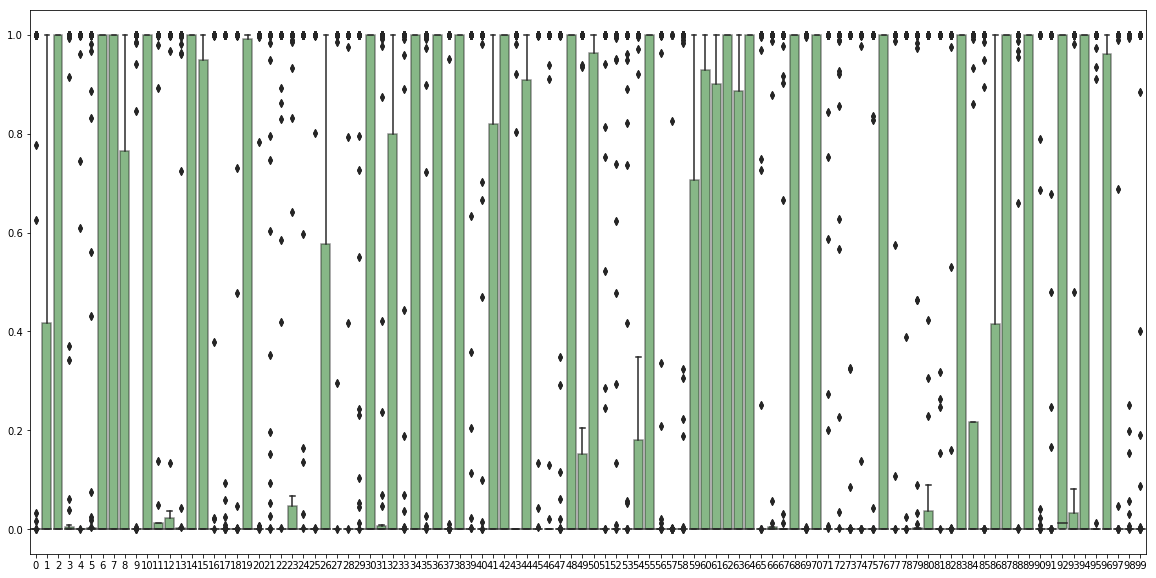

In [23]:
fig, ax = subplots(figsize=(20, 10))
sns.boxplot(data = pd.DataFrame(data=predict).iloc[:100,:].T, ax=ax,boxprops=dict(alpha=.5),color='g')

In [18]:
with h5py.File('/home/chenxupeng/projects/deepshape/data/new/train_0') as f:
    images_test = f['train_images'][:100]

In [20]:
def count_cor_wro(seq_counts):
    #seq_counts*4  correct counts  wrong counts nonnan counts
    nonnan_count = np.repeat(256,seq_counts)- np.sum(np.isnan(y_test[:seq_counts]),axis =1)
    unique_elements_cor, counts_elements_cor = np.unique(np.where(np.abs(y_test[:seq_counts,:] - y_test_) ==0)[0], return_counts=True)
    #unique_elements_wro, counts_elements_wro = np.unique(np.where(np.abs(y_test[:seq_counts,:] - y_test_) ==1)[0], return_counts=True)
    array = np.ndarray([seq_counts,4]).astype('int')
    array[:,:1] = np.arange(seq_counts).reshape(-1,1)
    array[unique_elements_cor,1:2] = counts_elements_cor.reshape(-1,1)
    array[:,3:4] = nonnan_count.reshape(-1,1)
    #array[unique_elements_wro,2:3] = counts_elements_wro.reshape(-1,1)
    array[:,2:3] = array[:,3:4] - array[:,1:2]
    acc = float(np.sum(array[:,1:2]))/float((np.sum(array[:,2:3]) + np.sum(array[:,1:2])))
    return array,acc

In [21]:
array,acc = count_cor_wro(3000)
cor_wro_table = pd.DataFrame(array)
cor_wro_table.columns = ['id', 'correct', 'wrong','nonnan']
cor_wro_table.head()

,id,correct,wrong,nonnan
0,0,6,12,18
1,1,10,0,10
2,2,4,2,6
3,3,28,8,36
4,4,10,12,22


(array([  36.,    1.,    5.,    8.,   16.,   19.,   22.,   38.,   23.,
          30.,   38.,   26.,   43.,   30.,   46.,   35.,  100.,   14.,
          42.,   58.,   57.,   73.,   63.,   55.,    5.,  187.,   42.,
          47.,  118.,   45.,   96.,   69.,   72.,  137.,  101.,   81.,
          67.,  123.,   57.,   88.,  156.,   72.,   28.,   69.,   89.,
          55.,   70.,    3.,    0.,  244.]),
 array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
         0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
         0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 50 Patch objects>)

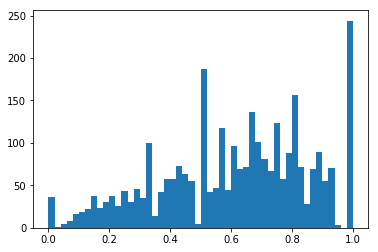

In [22]:
acc_distribution = np.around(array[:,1:2].astype('float') / (array[:,1:2] + array[:,2:3]),decimals=2).ravel()
hist(acc_distribution[~np.isnan(acc_distribution)],bins = 50)

需要核实代码！！完全nan的序列是怎么被选进去的？？？？还是哪一步写错了？

In [23]:
acc

0.5788795702461218

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 16) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 4640        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [31]:
model.get_config() 

{'input_layers': [['input_1', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128, 128, 16),
    'dtype': 'float32',
    'name': 'input_1',
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_1'},
  {'class_name': 'Conv2D',
   'config': {'activation': 'linear',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'filters': 32,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'distribution': 'uniform',
      'mode': 'fan_avg',
      'scale': 1.0,
      'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': (3, 3),
    'name': 'conv2d_1',
    'padding': 'same',
    'strides': (1, 1),
    'trainable': True,
    'use_bias': True},
   'inbound_nodes': [[['input_1', 0, 0, {}]]],
   'name': 'conv2d_1

Populating the interactive namespace from numpy and matplotlib


/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['concatenate', 'f', 'number']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


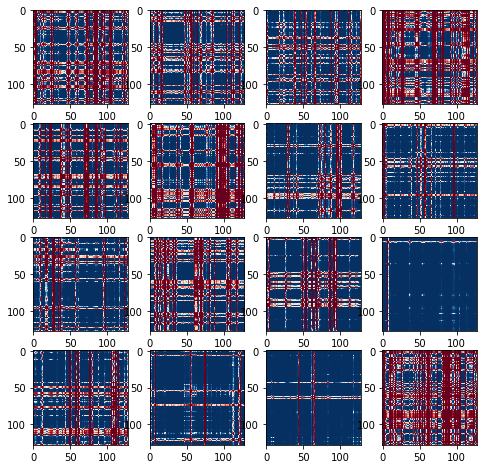

In [21]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function
# Testing
layer_outs = functor([images_test[:50], 1.])
#imshow 查看输出  94  91
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
    for j in range(4):
        ax[j,i].imshow(layer_outs[94][i*4+j,:,:,0],cmap=cm.RdBu_r)

In [ ]:
model

In [24]:
from keras.models import load_model
model = load_model('output/newunet_row_col_mse.hdf5')

ValueError: Unknown loss function:CrossEntropyLoss

In [30]:
b = np.load('/home/chenxupeng/projects/deepshape/output/unet_predict0.npy')

In [101]:
weights = h5py.File('output/newunet_weights_1.hdf5')

(array([ 1.,  0.,  2.,  1.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  3.,  1.,  2.,  0.,
         2.,  0.,  1.,  0.,  0.,  1.,  0.,  2.,  1.,  1.,  2.]),
 array([-0.402661  , -0.38678174, -0.37090249, -0.35502324, -0.33914399,
        -0.32326473, -0.30738548, -0.29150623, -0.27562698, -0.25974772,
        -0.24386847, -0.22798922, -0.21210997, -0.19623071, -0.18035146,
        -0.16447221, -0.14859295, -0.1327137 , -0.11683445, -0.1009552 ,
        -0.08507594, -0.06919669, -0.05331744, -0.03743819, -0.02155893,
        -0.00567968,  0.01019957,  0.02607882,  0.04195808,  0.05783733,
         0.07371658,  0.08959583,  0.10547509,  0.12135434,  0.13723359,
         0.15311284,  0.1689921 ,  0.18487135,  0.2007506 ,  0.21662985,
         0.23250911,  0.24838836,  0.26426761,  0.28014686,  0.29602612,
         0.31190537,  0.32778462,  0.34366387,  0.35954313,

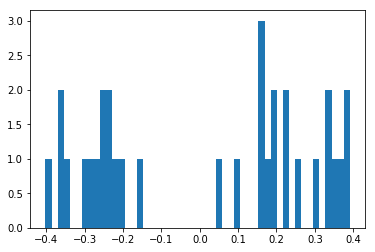

In [120]:
hist(weights['conv2d_69/conv2d_69/kernel:0'][:].flatten(),bins =50)

In [91]:
#model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 16) 0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 128, 128, 32) 4640        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 128, 128, 32) 128         conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 128, 128, 32) 0           batch_normalization_47[0][0]     
__________________________________________________________________________________________________
conv2d_48 

In [64]:
np.abs(weights[0]).flatten()

array([ 0.04075397,  0.05833072,  0.00320405, ...,  0.07187954,
        0.04653677,  0.07539184], dtype=float32)

In [66]:
np.max(np.abs(weights[0]).flatten())

0.31577942

In [32]:
c = {}
for i in range(1000):
    index = np.where(np.isnan(y_test[i]) ==0)[0]
    c[i] = b[i][index]

In [34]:
c[1]

array([ 0.07683542,  0.99696356,  0.58331442,  0.00804483,  0.93075985], dtype=float32)

In [17]:
a = {}
for i in range(1000):
    index = np.where(np.isnan(y_test[i]) ==0)[0]
    a[i] = y_test[i][index]

In [35]:
a[0]

array([ 1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.], dtype=float32)

In [21]:
count_0 = {}
count_1 = {}
ratio = {}
for i in range(1000):
    whole = a[i].shape[0]
    count_1[i] = np.sum(a[i])
    count_0[i] = whole -count_1[i]
#正样本的比例
    ratio[i] = count_1[i] / whole

In [25]:
ratio_ = np.array([val for key,val in ratio.iteritems()])
count_1_ = np.array([val for key,val in count_1.iteritems()])
count_0_ = np.array([val for key,val in count_0.iteritems()])

In [29]:
np.sum(count_1_)/(np.sum(count_1_)+np.sum(count_0_))

0.5087093899376165

In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['concatenate', 'f', 'number']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([ 59.,   0.,   2.,   8.,   5.,  14.,  10.,  19.,  14.,   7.,  28.,
         27.,  41.,  21.,  26.,  29.,  38.,  15.,  25.,  20.,  37.,  26.,
         24.,  11.,   0.,  78.,  21.,  20.,  23.,   6.,  33.,  23.,  11.,
         26.,  27.,  16.,  12.,  16.,  13.,   3.,  28.,  16.,  20.,  17.,
          8.,  23.,  10.,   8.,   1.,  35.]),
 array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
         0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
         0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 50 Patch objects>)

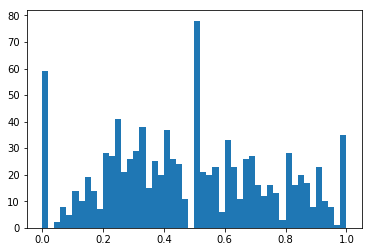

In [24]:
hist(ratio_,bins =50)

In [3]:
cd /home/chenxupeng/projects/deepshape/

/home/chenxupeng/projects/deepshape


In [12]:
#analyze model output

In [13]:
from keras.models import load_model
model = load_model('output/newunet_row_col.hdf5')
model.summary()

/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 16) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 4640        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [20]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function
# Testing
layer_outs = functor([images_test[:50], 1.])

In [22]:
layer_outs[94].shape

(50, 128, 128, 1)

In [30]:
#存一下输出
with h5py.File('newunet_row_col_output_mse') as f:
    for i in range(102):
        f.create_dataset(str(i),data = layer_outs[i])

In [35]:
def check_sym(array):
    out = ((array - array.T) ** 2).mean(axis=None)
    return out

In [24]:
mse = {}
for i in range(95):
    mse[i] = {}
    shape = layer_outs[i].shape
    for j in range(shape[0]):
        mse[i][j] = {}
        for t in range(shape[3]):
            mse[i][j][t]=check_sym(layer_outs[i][j,:,:,t])

In [25]:
#转换一层的dict to array
def dict_array(dict,t):
    array = np.ndarray([50,len(mse[t][0])])
    for i in range(len(mse[t])):
        array[i] = np.array([val for key,val in np.array([val for key,val in mse[t].iteritems()])[i].iteritems()])
    array = array.flatten()
    return array

In [24]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['concatenate', 'f', 'number']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [37]:
hist(dict_array(mse,94),bins = 50)

NameError: name 'dict_array' is not defined

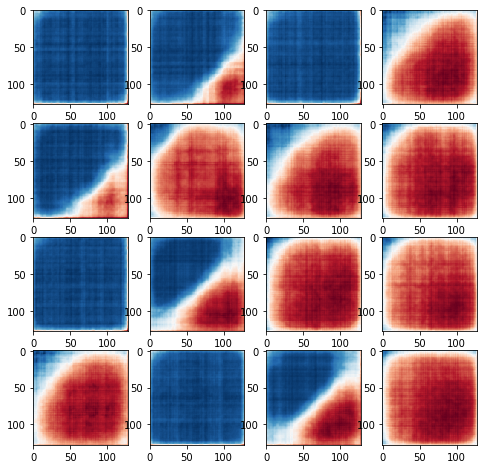

In [38]:
#imshow 查看输出  94  91
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
    for j in range(4):
        ax[j,i].imshow(layer_outs[94][i*4+j,:,:,0],cmap=cm.RdBu_r)


a = np.ndarray([y_train.shape[0],])
for i in range(y_train.shape[0]):
    a[i] = np.sum(np.isnan(y_train[i]))
%pylab inline
hist(a,bins = 50)


for i in range(num_test):
    accu = 0.0
    index = np.where(np.isnan(y_test_[i]) ==0)[0]
    count = index.shape[0]
    for j in range(count):
        if y_test_[i][index][j] == y_test_true[i][index][j]:
            accu +=1
    accu /=float(count) 
    acc +=accu
acc /=num_test
print("accuracy : ",acc)
